In [66]:
import pycbc.noise
from pycbc.noise import noise_from_psd
import pycbc.psd
import pylab as plt
import csv
from pycbc.waveform import get_td_waveform
import random
import numpy as np
from pycbc.types import TimeSeries, Array
import concurrent.futures

In [67]:
T = 4
flow = 30.0
delta_f = 1.0 / T
flen = int(2048 / delta_f) + 1
delta_t = 1.0 / 4096
tsamples = int(T / delta_t)

scale = 1500

In [68]:
# PSD
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)
noisesamples = int(4 / delta_t)

In [69]:
with open(
    "/home/arush/GW_Project_1/Data_Generation/Continous_Check/cont_data_train.csv",
    "w",
    newline="",
) as file:
    writer = csv.writer(file)
    writer.writerow(["M1", "M2", "Time", "SNR", "Path"])

In [70]:
def get_shifted_wvfrm(shift_percent):
    # WVFRM generation
    global hp, m1, m2
    m1 = random.randint(10, 30)
    m2 = random.randint(10, 30)

    print(m1, m2)
    hp, hc = get_td_waveform(
        approximant="IMRPhenomT",
        mass1=m1,
        mass2=m2,
        delta_t=1.0 / 4096,
        f_lower=30,
    )
    hp.resize(16384)
    hc.resize(16384)

    # Shift the waveform
    total_length = len(hp.sample_times)
    shift_index = int(shift_percent * total_length)
    shifted_data = np.zeros_like(hp.data)
    shift_amount = min(len(hp.data), total_length - shift_index)
    shifted_data[shift_index : shift_index + shift_amount] = hp.data[:shift_amount]
    ts = TimeSeries(shifted_data, delta_t=delta_t)
    return ts, m1, m2, hp


def get_noise(seed):
    noise = noise_from_psd(tsamples, delta_t, psd, seed=seed)
    return noise

In [71]:
def get_time_and_snr(template, signal):

    snr = pycbc.filter.matched_filter(
        template, signal, psd=psd, low_frequency_cutoff=flow
    )

    peak = abs(snr).numpy().argmax()
    snrp = abs(snr[peak])
    time = snr.sample_times[peak]

    return time, snrp

In [72]:
with open(
    "/home/arush/GW_Project_1/Data_Generation/Continous_Check/cont_data_train.csv",
    "w",
    newline="",
) as file:
    writer = csv.writer(file)
    writer.writerow(["M1", "M2", "Time", "SNR", "ChirpMass"])

In [73]:
def path(index):
    return f"Continous_Check/Data/signal_{index}.png"


def append_csv(csv_parameters_batch, index):
    def format_value(value):
        if isinstance(value, float):
            return f"{value:.3f}"
        return value

    with open(
        "/home/arush/GW_Project_1/Data_Generation/Continous_Check/cont_data_train.csv",
        "a",
        newline="",
    ) as file:
        writer = csv.writer(file)
        for i, row in enumerate(csv_parameters_batch):
            formatted_row = [format_value(value) for value in row]
            row_with_path = formatted_row + [path(i + index)]
            writer.writerow(row_with_path)


def save_specgram(waveforms, index):
    print("Save spectrogram started")
    for i, waveform in enumerate(waveforms):
        plt.specgram(waveform, Fs=2048)
        plt.axis("off")
        plt.savefig(
            f"/home/arush/GW_Project_1/Data_Generation/{path(i+index)}",
            bbox_inches="tight",
            pad_inches=0,
        )
        plt.close()
        print("Spectrogram saved", (i + index))

In [74]:
def save_func(csv_parameters_batch, waveforms, index):
    print("save func executed")

    with concurrent.futures.ProcessPoolExecutor() as executor:
        futures = [
            executor.submit(append_csv, csv_parameters_batch, index),
            executor.submit(save_specgram, waveforms, index),
        ]

        for future in concurrent.futures.as_completed(futures):
            print(future.result())

In [75]:
l = 0
batch_size = 25
batch_data = []
waveforms = []

In [76]:
def process_waveform(l):
    random_shift_var = random.uniform(0, 0.7)
    waveform, m1, m2, template = get_shifted_wvfrm(random_shift_var)
    noise = get_noise(l)
    signal = (waveform / scale) + noise

    time, snr = get_time_and_snr(template=template, signal=signal)
    chirp_m = ((m1 * m2) ** (3 / 5)) / ((m1 + m2) ** (1 / 5))
    csv_append = [m1, m2, time, snr, chirp_m]

    return csv_append, signal

In [77]:
def main():
    batch_size = 50
    total_iterations = 2000
    for start in range(0, total_iterations, batch_size):
        print("start: ", start)
        batch_data = []
        waveforms = []
        end = min(start + batch_size, total_iterations)
        with concurrent.futures.ProcessPoolExecutor() as executor:
            futures = [executor.submit(process_waveform, l) for l in range(start, end)]
            for future in concurrent.futures.as_completed(futures):
                csv_append, waveform = future.result()
                batch_data.append(csv_append)
                waveforms.append(waveform)
        save_func(batch_data, waveforms, start)

In [78]:
main()

start:  0
221617133011292913202317 25 1611 11        12 13   161822 3018181118
232214
211120













17 28
23 10 202620 
 3014
 2112

17 29
21 15
12
26 24
20 13
19 21
10 15
11 29
28 26
19 24
12 27
19 13
27 13
26 2926
 2220
 22 16
 2124
1410
 2910
 28
14 28
15 13
26 24
11 10
21 15
14 20
14 30
18 27
17 16
save func executed
None
Save spectrogram started
Spectrogram saved 0
Spectrogram saved 1
Spectrogram saved 2
Spectrogram saved 3
Spectrogram saved 4
Spectrogram saved 5
Spectrogram saved 6
Spectrogram saved 7
Spectrogram saved 8
Spectrogram saved 9
Spectrogram saved 10
Spectrogram saved 11
Spectrogram saved 12
Spectrogram saved 13
Spectrogram saved 14
Spectrogram saved 15
Spectrogram saved 16
Spectrogram saved 17
Spectrogram saved 18
Spectrogram saved 19
Spectrogram saved 20
Spectrogram saved 21
Spectrogram saved 22
Spectrogram saved 23
Spectrogram saved 24
Spectrogram saved 25
Spectrogram saved 26
Spectrogram saved 27
Spectrogram saved 28
Spectrogram saved 29
Spectrogram saved 30


/tmp/ipykernel_4661/3285702392.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


    M1     M2    Time     SNR                          ChirpMass
29  30  1.889  25.117  25.677  Continous_Check/Data/signal_0.png
11  16  1.009  11.555  11.509  Continous_Check/Data/signal_1.png
13  18  2.473  14.938  13.282  Continous_Check/Data/signal_2.png
11  20  1.711  13.163  12.799  Continous_Check/Data/signal_3.png
20  18  0.361  16.064  16.513  Continous_Check/Data/signal_4.png


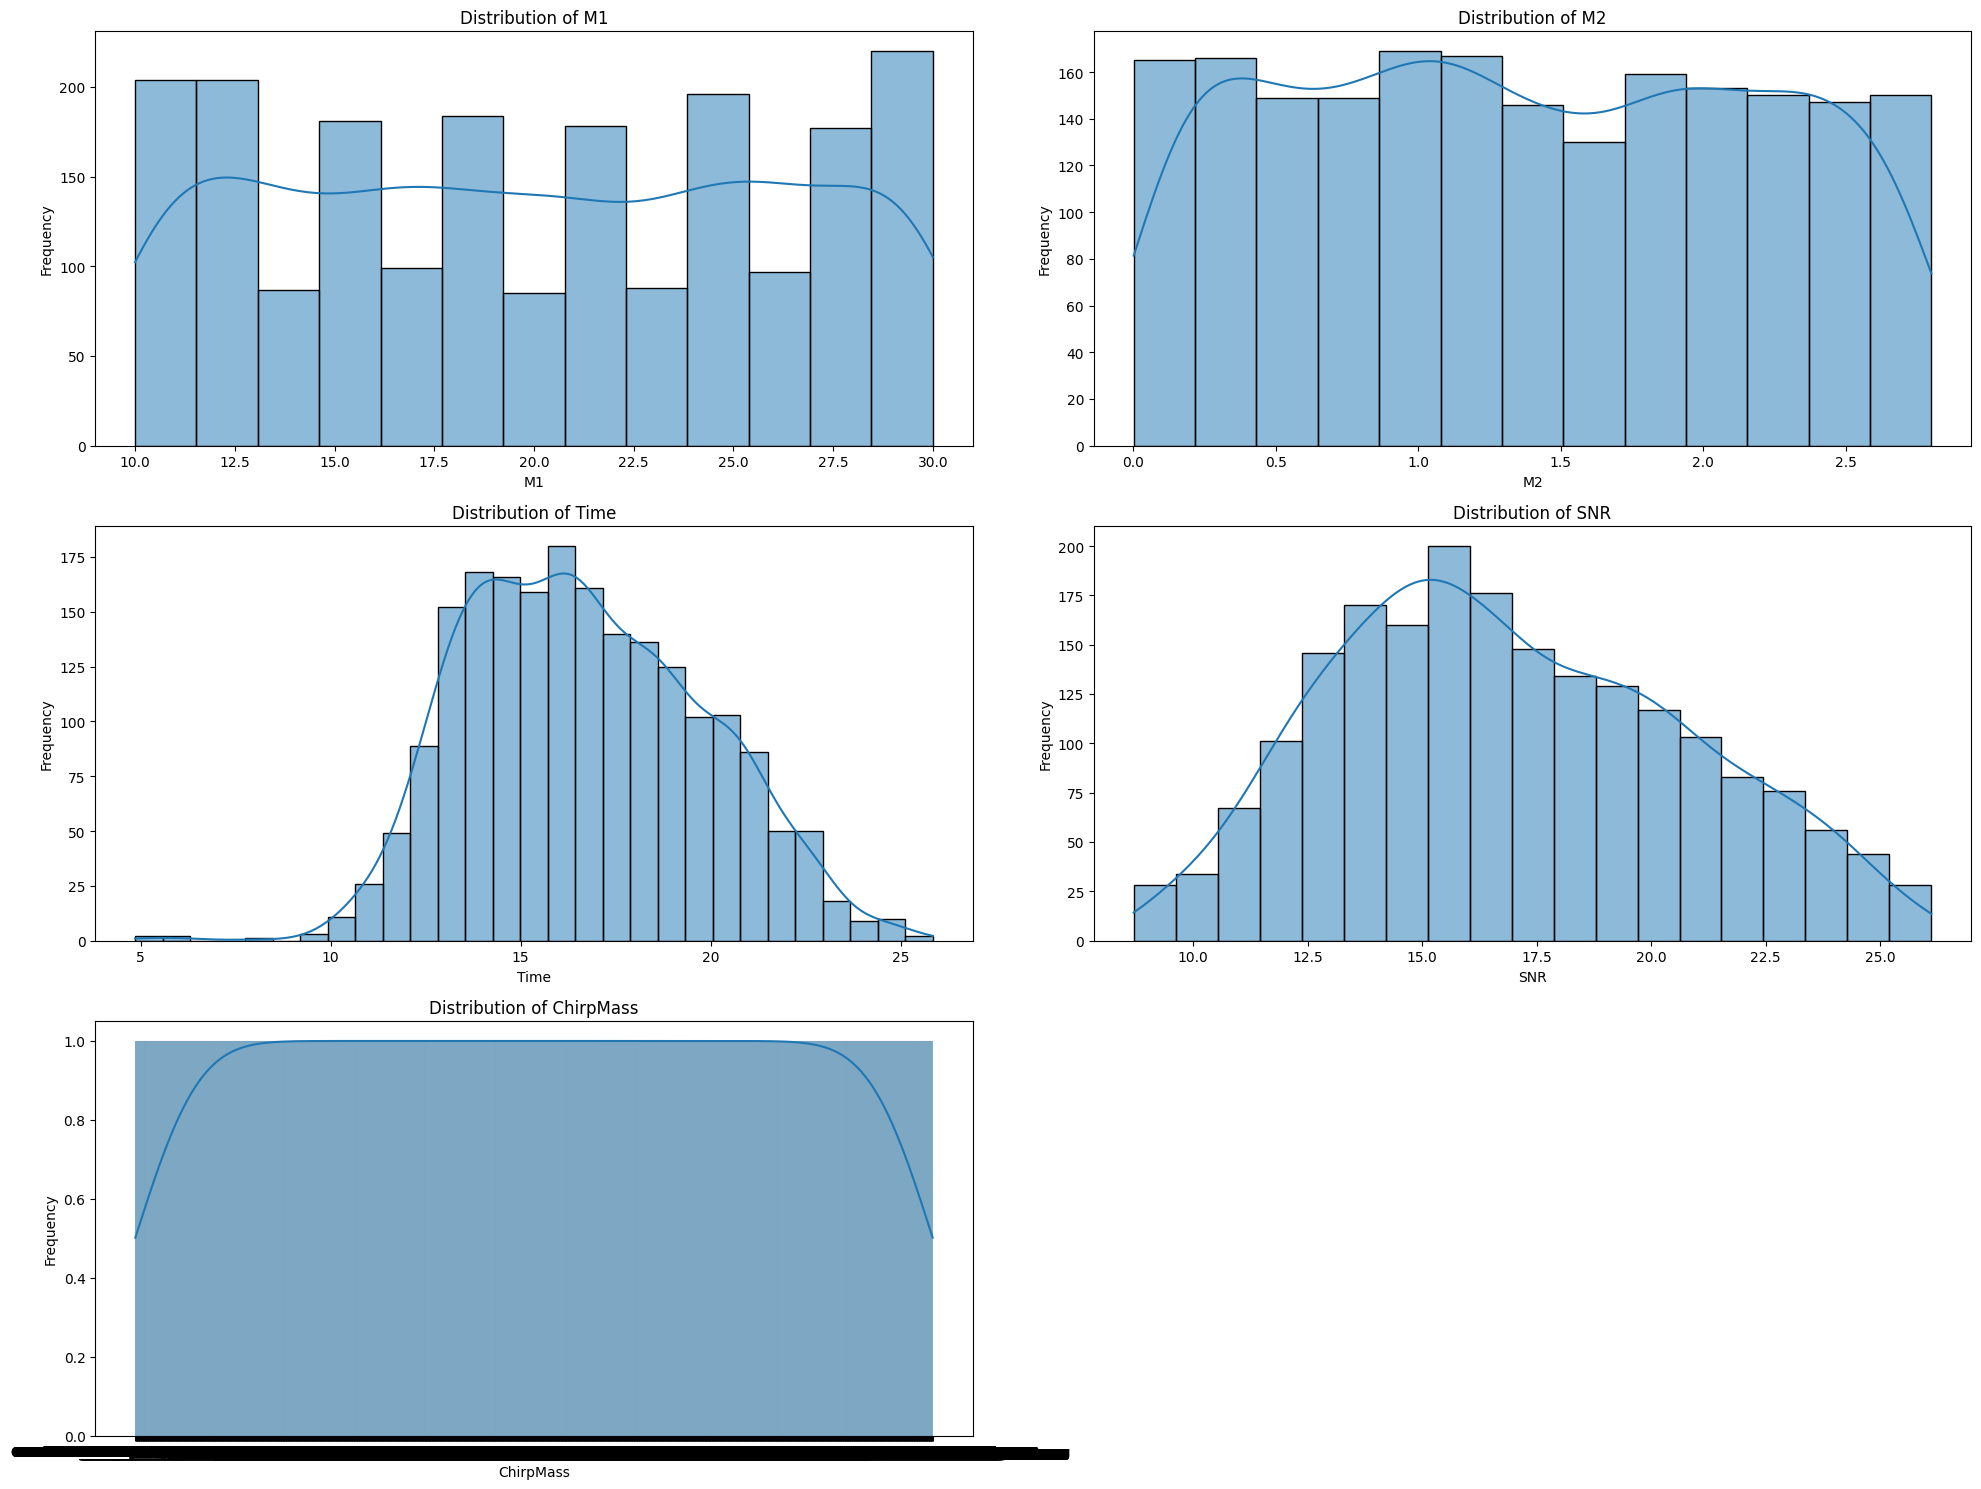

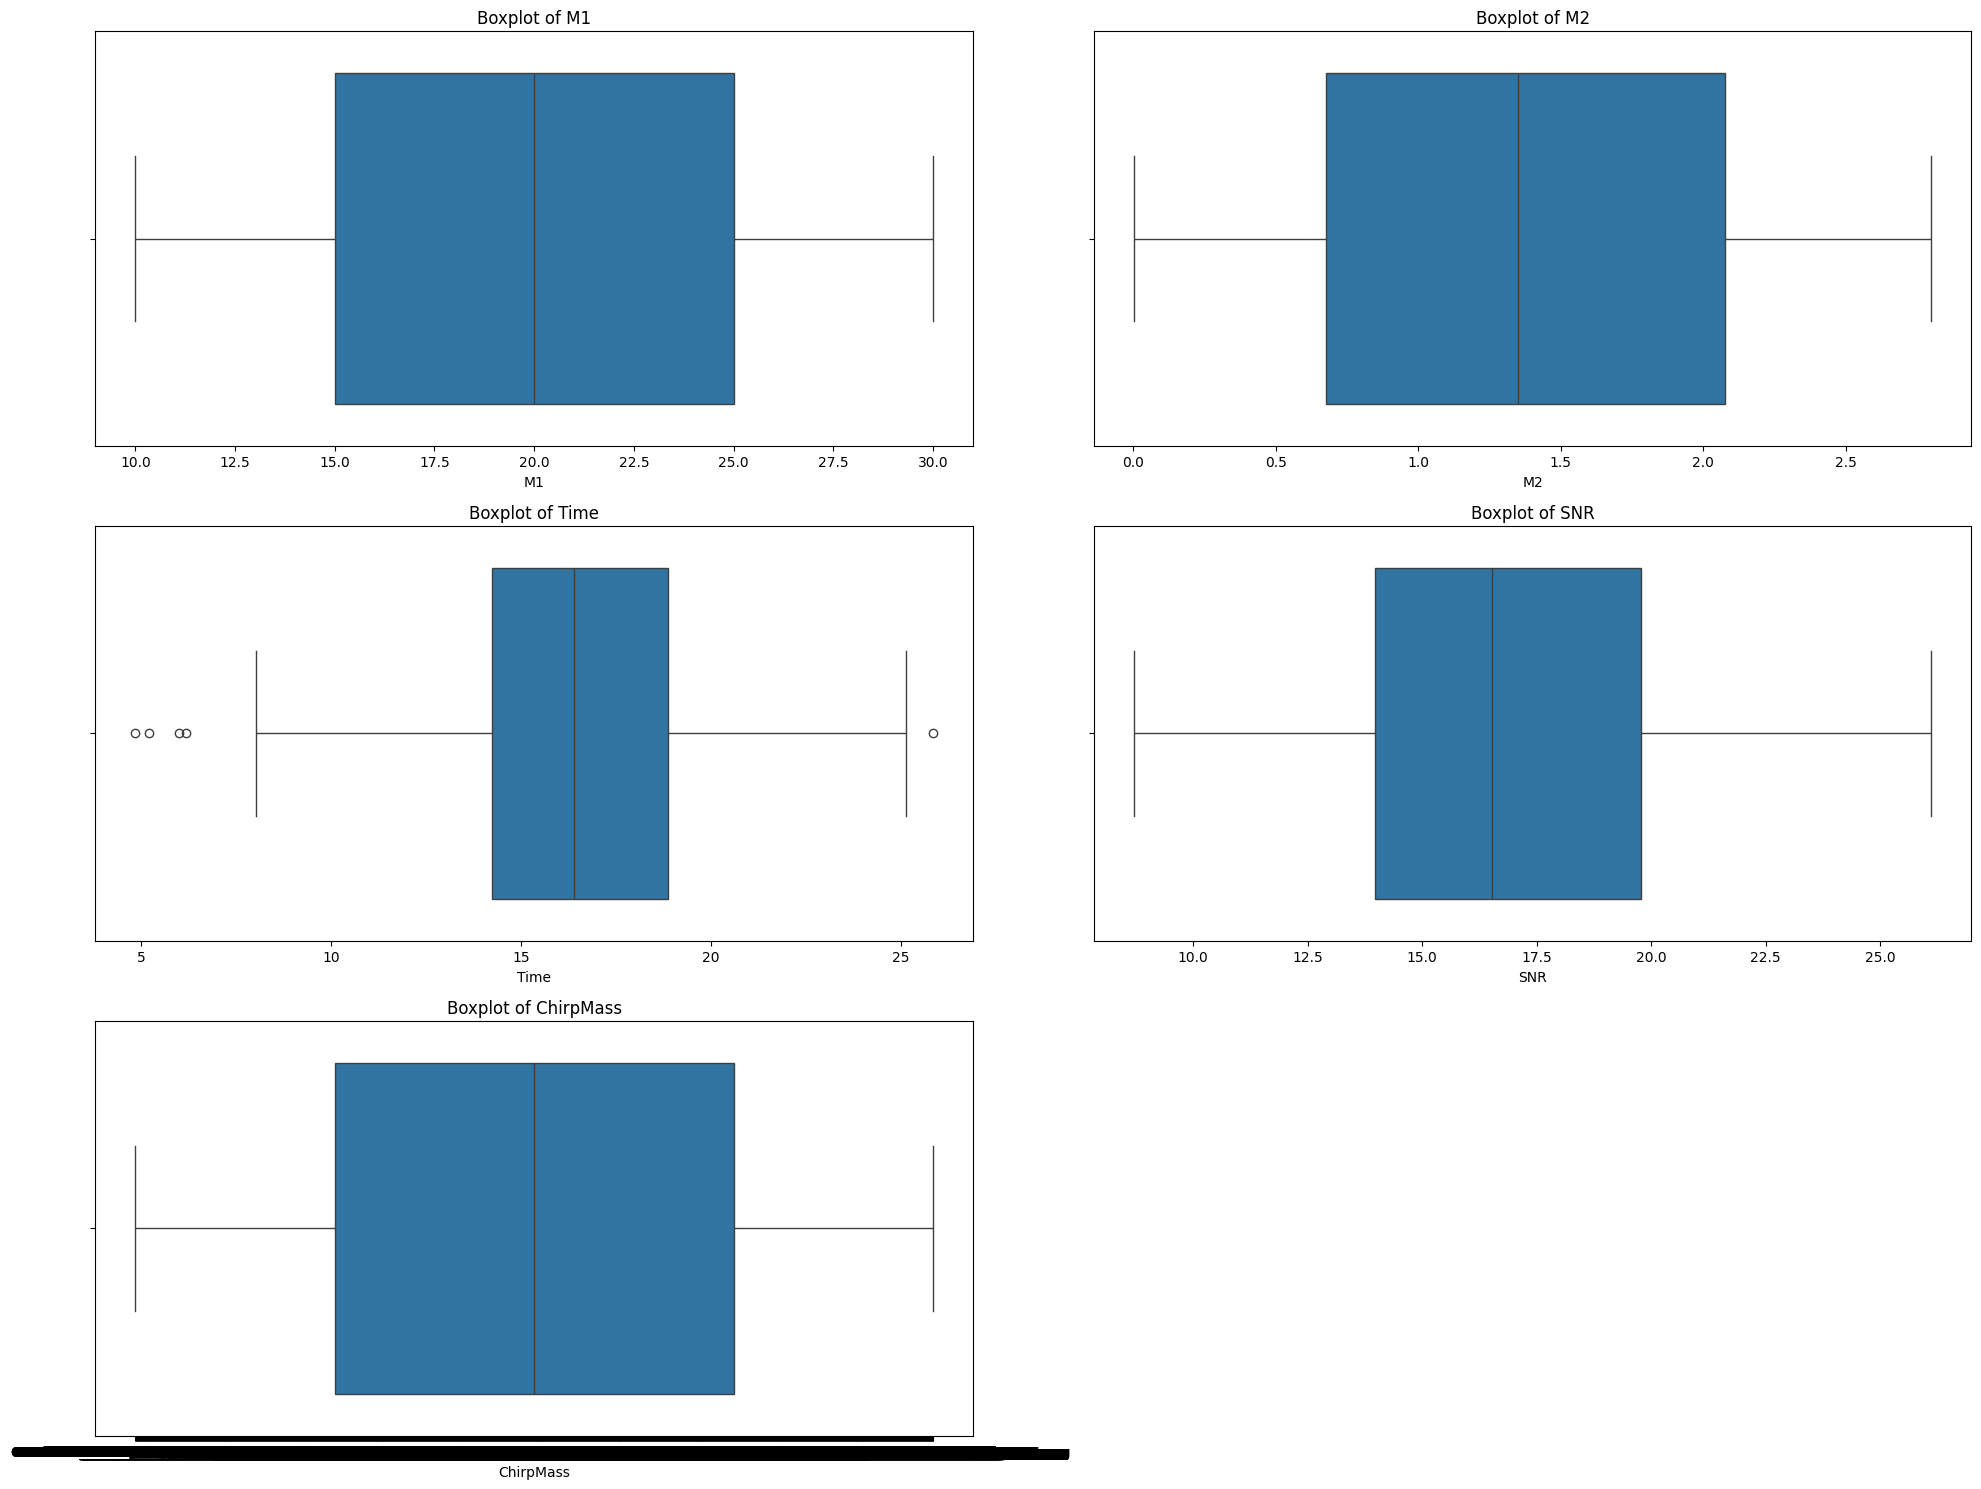

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
df = pd.read_csv(
    "/home/arush/GW_Project_1/Data_Generation/Continous_Check/cont_data_train.csv"
)

# Display the first few rows of the dataframe to ensure it's loaded correctly
print(df.head())

# Plot the distribution of each parameter
parameters = ["M1", "M2", "Time", "SNR", "ChirpMass"]

plt.figure(figsize=(20, 15))

for i, param in enumerate(parameters):
    plt.subplot(3, 2, i + 1)
    sns.histplot(df[param], kde=True)
    plt.title(f"Distribution of {param}")
    plt.xlabel(param)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Plot boxplots to check for outliers
plt.figure(figsize=(20, 15))

for i, param in enumerate(parameters):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(x=df[param])
    plt.title(f"Boxplot of {param}")
    plt.xlabel(param)

plt.tight_layout()
plt.show()